# Eurovision winner prediction project

In [55]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import time
import re
from dotenv import load_dotenv
import os 
import base64
from requests import post,get
import json
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.common.by import By
import pycountry
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import geopandas as gpd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,f1_score


from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from IPython.display import Image, display  
import pydotplus 
from scipy import misc

## Crawling

<div class="alert alert-block alert-info">
<b>This function creates a Beautiful Soup object. At first, we received a 403 request response. To avoid this issue, we used a User-Agent and it solved our problem.</b>
</div>

In [2]:
def load_soup_object(url):
    headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36 Edg/110.0.1587.57'}
    response = requests.get(url,headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")
    return soup


<div class="alert alert-block alert-info">
<b>Here we are scraping all information about the winners of Eurovision, including the year of the event, hosted city, winning country, artist names, songs, the number of points each country received, and URLs to scrape for additional data. We then store all this information in a DataFrame. </b>
</div>




In [3]:
def scrape_winners_data(eurovision_url,total_pages):
    year=[]
    city=[]
    winners=[]
    participant=[]
    song=[]
    points=[]
    urls=[]
    soup = load_soup_object(eurovision_url)
    
    #winners data:
    for i in range(total_pages):
        for data in soup.find_all("div",{'class':'archive-block'}):
            for tag_year in data.find_all("td",{'class':'views-field views-field-field-event-year'}):
                if(tag_year is not None):
                    year.append(tag_year.get_text().strip())
                else:
                    year.append("NaN")
                for tag_url in tag_year.findAll("a"):
                    if(tag_url is not None):
                        urls.append(f"https://eurovision.tv" + tag_url['href'])
                    else:
                        urls.append("NaN")
            for tag_city in data.find_all("td",{'class':'views-field views-field-field-country-alpha-2'}):
                if(tag_city is not None):
                    city.append(tag_city.get_text().strip())
                else:
                    city.append("NaN")
            for tag_winners in data.find_all("td",{'class':'views-field views-field-field-country-1'}):
                if(tag_winners is not None):
                    winners.append(tag_winners.get_text().strip())
                else:
                    winners.append("NaN")
            for tag_participant in data.find_all("td",{'class':'views-field views-field-field-featured-image'}):
                if(tag_participant is not None):
                    participant.append(tag_participant.get_text().strip())
                else:
                    participant.append("NaN")
            for tag_points in data.find_all("td",{'headers':'view-field-participation-total-points-table-column'}):
                if(tag_points is not None):
                    points.append(tag_points.get_text().strip())
                else:
                    points.append("NaN")
            for tag_song in data.find_all("td",{'class':'views-field views-field-field-participant-perf-video'}):
                if(tag_song is not None):
                    song.append(tag_song.get_text().strip())
                else:
                    song.append("NaN")
        time.sleep(20)
        nav= soup.find("li",{"class":"pager__item pager__item--next"})
        if(nav):
            soup=load_soup_object(eurovision_url+nav.find('a')['href'])
          
    df = pd.DataFrame({'Year':year,'City':city,'Winner':winners,'Participant':participant,'Song':song,'Points':points,'Links':urls})
    return df

In [4]:
eurovision_url=f"https://eurovision.tv/history"
winners_df = scrape_winners_data(eurovision_url,5)

In [5]:
winners_df

,Year,City,Winner,Participant,Song,Points,Links
0,2023,Liverpool,Sweden,Loreen,Tattoo,583,https://eurovision.tv/event/liverpool-2023
1,2022,Turin,Ukraine,Kalush Orchestra,Stefania,631,https://eurovision.tv/event/turin-2022
2,2021,Rotterdam,Italy,Måneskin,Zitti E Buoni,524,https://eurovision.tv/event/rotterdam-2021
3,2019,Tel Aviv,Netherlands,Duncan Laurence,Arcade,498,https://eurovision.tv/event/tel-aviv-2019
4,2018,Lisbon,Israel,Netta,TOY,529,https://eurovision.tv/event/lisbon-2018
...,...,...,...,...,...,...,...
65,1960,London,France,Jacqueline Boyer,,32,https://eurovision.tv/event/london-1960
66,1959,Cannes,Netherlands,Teddy Scholten,,21,https://eurovision.tv/event/cannes-1959
67,1958,Hilversum,France,André Claveau,,27,https://eurovision.tv/event/hilversum-1958
68,1957,Frankfurt am Main,Netherlands,Corry Brokken,Net Als Toen,31,https://eurovision.tv/event/frankfurt-1957


In [6]:
winners_df.to_csv("winners_df.csv")


<div class="alert alert-block alert-info">
<b> 
In this section, we are using the URLs we scraped earlier to obtain information about all participants in Eurovision from the years 1956-2022, including their songs, points, ranks, and whether they qualified for the final. The competition format varied throughout the years, with only one round (the final) between 1956-2003, two rounds (semi-final and grand final) between 2004-2007, and three rounds (two semi-finals and a final) from 2008-2022. We had to take these variations into account while scraping the data.   
</b>
</div>

In [7]:
def scrape_participants_data(links):
    country=[]
    participant=[]
    song=[]
    points=[]
    competition_type=[]
    qualified=[]
    year=[]
    rank=[]
    urls = ["/first-semi-final","/second-semi-final","/semi-final","/grand-final","/final"]
    
 
    for l in links:
        for url in urls:
            soup = load_soup_object(l + url)
            for data in soup.find_all("div",{'class':'winner-included__tab-content'}):
                for tag_country in data.find_all("td",{'headers':'view-title-1-table-column'}):
                    if(tag_country):
                        country.append(tag_country.get_text().strip())
                    else:
                        country.append("NaN")
                for tag_participant in data.find_all("td",{'headers':'view-title-table-column'}):
                    for tag_p in tag_participant.find_all('a'):
                        if(tag_p):
                            participant.append(tag_p.get_text().strip())
                        else:
                            participant.append("NaN")
                        tq=tag_participant.find("span",{'class':'qualified'})
                        if(tq):
                            qualified.append("yes")
                        else:
                            if(url == "/grand-final" or url == "/final"):
                                qualified.append("NaN")
                            else:
                                qualified.append("no")
                for tag_song in data.find_all("td",{'headers':'view-field-participant-perf-video-table-column'}):
                    if(tag_song):
                        song.append(tag_song.get_text().strip())
                    else:
                        song.append("NaN")
                for tag_rank in data.find_all("td",{'headers':'view-field-participation-rank-table-column'}):
                    if(tag_rank):
                        rank.append(tag_rank.get_text().strip())
                    else:
                        rank.append("NaN")
                for tag_points in data.find_all("td",{'headers':'view-field-participation-total-points-table-column'}):
                    if(tag_points):
                        points.append(tag_points.get_text().strip())
                    else:
                        points.append("NaN")
                    year1 = soup.find("div",{'class':'winner-layout__title'})
                    extract_year =re.findall('\d+',year1.get_text().strip())
                    if(extract_year):
                        year.append(extract_year[0])
                    else:
                        year.append("NaN")
                    competition = soup.find("div",{'class':'winner-layout__tabs-wrapper js-tabs-wrapper'})
                    ctag = competition.find("a",{'class':'winner-layout__tab js-tab-item active'})
                    if(ctag):
                        competition_type.append(ctag.get_text().strip())
                    else:
                        competition_type.append("NaN")
            if(int(year[len(year)-1]) < 2004 and url != "/final"):
                continue
            if(int(year[len(year)-1]) in  range(2004,2007) and (url!="/semi-final" or url!="/grand-final") ):
                continue
            time.sleep(20)
    
    df = pd.DataFrame({'Year':year,'Country':country,'Participant':participant,'Song':song,'Points':points,'Competition':competition_type,'Qualified':qualified,'Rank':rank})
    return df
    

In [8]:
links = winners_df["Links"].tolist()
df_participants = scrape_participants_data(links)

In [9]:
df_participants

,Year,Country,Participant,Song,Points,Competition,Qualified,Rank
0,2023,Norway,Alessandra,Queen of Kings,102,First Semi-Final,yes,6th
1,2023,Malta,The Busker,Dance (Our Own Party),3,First Semi-Final,no,15th
2,2023,Serbia,Luke Black,Samo Mi Se Spava,37,First Semi-Final,yes,10th
3,2023,Latvia,Sudden Lights,Aijā,34,First Semi-Final,no,11th
4,2023,Portugal,Mimicat,Ai Coração,74,First Semi-Final,yes,9th
...,...,...,...,...,...,...,...,...
2064,1956,Belgium,Mony Marc,Le Plus Beau Jour De Ma Vie,,Final,NaN,2nd
2065,1956,Germany,Freddy Quinn,So Geht Das Jede Nacht,,Final,NaN,2nd
2066,1956,France,Dany Dauberson,Il Est Là,,Final,NaN,2nd
2067,1956,Luxembourg,Michèle Arnaud,Les Amants De Minuit,,Final,NaN,2nd


In [10]:
df_participants.to_csv("participants_df.csv")


## API

<div class="alert alert-block alert-info">
<b> In this cell, we are using the Spotify API to scrape audio features for all songs that have been performed at Eurovision.
   To access the required resource, we first requested an access token. Then, we searched for the artist name and song to obtain the song ID. After obtaining the song ID, we retrieved the audio features for each song and saved it in JSON format. We later utilized this data to save it into a DataFrame.
    </b>
</div>

In [11]:
load_dotenv() #loading the client id and client secret from .env file
client_id=os.getenv("CLIENT_ID")
client_secret=os.getenv("CLIENT_SECRET")

def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes=auth_string.encode("utf-8")
    auth_base64=str(base64.b64encode(auth_bytes),"utf-8")
    
    url="https://accounts.spotify.com/api/token"
    headers={
        "Authorization": "Basic " +  auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data={"grant_type":"client_credentials"}
    result=post(url,headers=headers,data=data)
    json_result=json.loads(result.content)
    token=json_result["access_token"]
    return token

def get_auth_header(token):
    return {"Authorization":"Bearer " + token}

def search_for_artist_and_track(token,artist_name,track):
    url="https://api.spotify.com/v1/search"
    headers=get_auth_header(token)
    query = f"?q={artist_name,track}&type=artist,track&limit=1"
    query_url = url + query
    result =get(query_url,headers=headers)
    if result.status_code == 200:
        json_result=json.loads(result.content)["tracks"]["items"]
    else:
        return None
    if len(json_result)==0:
        return None
    return json_result[0]
def get_audio_features(track_id,token):
    url="https://api.spotify.com/v1/audio-features/"
    headers=get_auth_header(token)
    query=f"{track_id}"
    query_url=url+query
    result =get(query_url,headers=headers)
    json_result=json.loads(result.content)
    return json_result

In [12]:
danceability=[]
energy=[]
key=[]
loudness=[]
mode=[]
speechiness=[]
acousticness=[]
instrumentalness=[]
liveness=[]
valence=[]
tempo=[]
duration_ms=[]

token = get_token()


artists = df_participants["Participant"].tolist()
songs = df_participants["Song"].tolist()

for a,s in zip(artists,songs):
    result = search_for_artist_and_track(token,a,s)
    if result != None:
        track_id = result["id"]
        res=get_audio_features(track_id,token)
        danceability.append(res["danceability"])
        energy.append(res["energy"])
        key.append(res["key"])
        loudness.append(res["loudness"])
        mode.append(res["mode"])
        speechiness.append(res["speechiness"])
        acousticness.append(res["acousticness"])
        instrumentalness.append(res["instrumentalness"])
        liveness.append(res["liveness"])
        valence.append(res["valence"])
        tempo.append(res["tempo"])
        duration_ms.append(res["duration_ms"])
    else:
        danceability.append("NaN")
        energy.append("NaN")
        key.append("NaN")
        loudness.append("NaN")
        mode.append("NaN")
        speechiness.append("NaN")
        acousticness.append("NaN")
        instrumentalness.append("NaN")
        liveness.append("NaN")
        valence.append("NaN")
        tempo.append("NaN")
        duration_ms.append("NaN")
    

In [13]:
df_participants["danceability"]=danceability
df_participants["energy"]=energy
df_participants["key"]=key
df_participants["loudness"]=loudness
df_participants["mode"]=mode
df_participants["speechiness"]=speechiness
df_participants["acousticness"]=acousticness
df_participants["instrumentalness"]=instrumentalness
df_participants["liveness"]=liveness
df_participants["valence"]=valence
df_participants["tempo"]=tempo
df_participants["duration_ms"]=duration_ms


In [14]:
df_participants.to_csv("participants_df.csv")


In [15]:
df_participants

,Year,Country,Participant,Song,Points,Competition,Qualified,Rank,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2023,Norway,Alessandra,Queen of Kings,102,First Semi-Final,yes,6th,0.563,0.908,4,-4.25,0,0.0868,0.0696,0,0.328,0.171,125.972,147980
1,2023,Malta,The Busker,Dance (Our Own Party),3,First Semi-Final,no,15th,0.695,0.778,5,-5.634,0,0.0407,0.0217,0.00359,0.182,0.824,103.015,169515
2,2023,Serbia,Luke Black,Samo Mi Se Spava,37,First Semi-Final,yes,10th,0.551,0.73,9,-8.288,1,0.0575,0.00839,0.00348,0.443,0.124,103.031,173592
3,2023,Latvia,Sudden Lights,Aijā,34,First Semi-Final,no,11th,0.556,0.548,9,-7.513,0,0.0694,0.0523,0.00011,0.0781,0.398,160.071,180782
4,2023,Portugal,Mimicat,Ai Coração,74,First Semi-Final,yes,9th,0.664,0.626,6,-8.197,0,0.0515,0.31,0.000005,0.163,0.766,145.14,174123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,1956,Belgium,Mony Marc,Le Plus Beau Jour De Ma Vie,,Final,NaN,2nd,0.704,0.28,0,-11.197,1,0.0281,0.325,0.00213,0.116,0.323,144.037,214440
2065,1956,Germany,Freddy Quinn,So Geht Das Jede Nacht,,Final,NaN,2nd,0.643,0.696,5,-5.958,1,0.059,0.561,0,0.3,0.896,97.339,124600
2066,1956,France,Dany Dauberson,Il Est Là,,Final,NaN,2nd,0.281,0.208,1,-9.597,1,0.0351,0.963,0.000002,0.102,0.364,83.6,175726
2067,1956,Luxembourg,Michèle Arnaud,Les Amants De Minuit,,Final,NaN,2nd,0.387,0.232,11,-9.529,1,0.0388,0.948,0,0.0679,0.154,99.369,157100


## Selenium

<div class="alert alert-block alert-info">
<b>Here we are scraping votes details from the years 1957 to 2023, we skipped 1956 year because in 1956 the voting was secret and never made public. The vote details consist of the number of points each country received in the final round, the year of the event and the total points accumulated from all participating countries. After we tried to extract information using Beautiful Soup object and failed, we used selenium instead. In addition there was another difficulty, the countries in the table were displayed as ISO codes, so we used pycountry library to translate the codes into contry names. </b>
</div>

In [16]:
def country_flag(country_code):
    list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)] 
    list_alpha_3 = [i.alpha_3 for i in list(pycountry.countries)]
    if (len(country_code)==2 and country_code in list_alpha_2):
        return pycountry.countries.get(alpha_2=country_code).name
    elif (len(country_code)==3 and country_code in list_alpha_3):
        return pycountry.countries.get(alpha_3=country_code).name
    else:
        return 'Invalid Code'

In [17]:
def scrape_votes_data(url,years):
    
    to_country=[]
    total_points=[]
    #public_points=[]
    #jury_points=[]
    year=[]
    countries_name=[]
    list_dict = {} #dictionary of lists for votes per country
    data = []
    from_countries=['Albania','Armenia', 'Australia', 'Austria',
                    'Azerbaijan','Belarus', 'Belgium','Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 
                    'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 
                    'France', 'Georgia', 'Germany', 'Greece','Hungary', 'Iceland',
                    'Ireland', 'Israel', 'Italy','Kazakhstan', 'Latvia', 'Lithuania', 'Luxembourg',
                    'Malta','Moldova, Republic of','Monaco', 'Montenegro', 'Netherlands', 
                    'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania','Russian Federation',
                    'San Marino','Serbia','Slovakia','Slovenia', 'Spain', 'Sweden', 'Switzerland',
                    'Turkey','Ukraine', 'United Kingdom']
    countries = {}
    for country in pycountry.countries:
        countries[country.name] = country.alpha_2

    codes = [countries.get(country, 'Unknown code').lower() for country in from_countries]
    
    for y in years[:65]:
        driver=webdriver.Chrome()
        driver.get(url+str(y))
        time.sleep(10)
        to_countries = driver.find_elements(By.XPATH,'//table[@class="scoreboard_table"]/tbody/tr/td[@class="scoreboard_land_click"]')
        total_points_data= driver.find_elements(By.XPATH,'//table[@class="scoreboard_table"]/tbody/tr/td/b')       
        length=len(driver.find_elements(By.XPATH,'//table[@class="scoreboard_table"]/tbody/tr'))
        for code in codes:
            country_name = country_flag(code.upper())
            list_dict.setdefault(country_name, [])
            data = driver.find_elements(By.XPATH,'//table[@class="scoreboard_table"]/tbody/tr/td[@data-from="' + code +'"]')
            if(len(data)>0):
                for d in data:
                    list_dict[country_name].append(d.text)
            else:
                for i in range(length):
                    list_dict[country_name].append("NaN")
        for i in range(length):
            year.append(y)
        for t in to_countries:
            to_country.append(t.text)  
        for p in total_points_data:
            total_points.append(p.text)
            

            
   
    df = pd.DataFrame.from_dict(list_dict,orient='index').transpose()
    df.insert(0, "To_Country", to_country)
    df.insert(1, "Year", year)
    df.insert(2, "Total_Points", total_points)
   


    return df


    
    
            
    

In [19]:
url=f"https://eurovisionworld.com/eurovision/"
winners_df = pd.read_csv('winners_df.csv')
years = winners_df["Year"].tolist()
years = list(dict.fromkeys(years))
votes_df = scrape_votes_data(url,years)

In [20]:
round_type=[]
for i in range(len(votes_df["Year"])):
    round_type.append("final")

In [21]:
votes_df.to_csv("votes_df.csv")

In [22]:
votes_df

,To_Country,Year,Total_Points,Albania,Armenia,Australia,Austria,Azerbaijan,Belarus,Belgium,...,San Marino,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,Turkey,Ukraine,United Kingdom
0,Sweden,2023,583,22,17,17,14,20,NaN,18,...,12,11,NaN,11,17,,11,NaN,15,17
1,Finland,2023,526,6,14,17,20,11,NaN,17,...,12,19,NaN,10,13,24,8,NaN,10,12
2,Israel,2023,362,11,24,5,1,24,NaN,15,...,10,17,NaN,,15,5,4,NaN,2,7
3,Italy,2023,350,14,3,1,20,10,NaN,14,...,19,4,NaN,20,16,13,18,NaN,2,2
4,Norway,2023,268,4,8,6,7,2,NaN,8,...,5,5,NaN,5,10,18,6,NaN,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370,Austria,1958,8,NaN,NaN,NaN,,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,1,2,NaN,NaN,NaN
1371,Germany,1958,5,NaN,NaN,NaN,1,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,1,,NaN,NaN,NaN
1372,Denmark,1958,3,NaN,NaN,NaN,,NaN,NaN,,...,NaN,NaN,NaN,NaN,NaN,1,,NaN,NaN,NaN
1373,Netherlands,1958,1,NaN,NaN,NaN,,NaN,NaN,,...,NaN,NaN,NaN,NaN,NaN,,1,NaN,NaN,NaN


## Union of dataframes

<div class="alert alert-block alert-info">
<b>In this section, we merge our dataframes. First, we use only the final round of participants dataframe because our votes dataframe is only for the final round. Then, we remove duplicates from the participants dataframe and remove rows with the year 1956 because the votes for that year are unknown. Finally, we rename the "Country" column to "To_Country" and "Competition" to "Round" of participants dataframe for successful merging and remove 'Qualified' column because we use all countries that are alredy qualified for final. After that, we merge the dataframes.</b>
</div>


In [24]:


df_participants = df_participants.drop_duplicates()
df_participants['Year'] = df_participants['Year'].astype(int)

new_df = df_participants.loc[df_participants['Competition'].isin(['Final', 'Grand Final'])]
df_prts = new_df[new_df.Year != 1956]
df_prts_new = df_prts.rename({'Country': 'To_Country','Competition':'Round','Points':'Total_Points'}, axis=1)

#all the rows from the left dataframe (df_prts_new) will be included 
#in the merged dataframe, and any matching rows from the right dataframe (votes_df) will be added as well.
merged_df = pd.merge(df_prts_new, votes_df, on=['Year', 'To_Country','Total_Points'],how='left') 
merged_df = merged_df.drop('Qualified', axis=1)
merged_df.to_csv("merged_df.csv")
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1384
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Year                    1385 non-null   int32 
 1   To_Country              1385 non-null   object
 2   Participant             1385 non-null   object
 3   Song                    1385 non-null   object
 4   Total_Points            1385 non-null   object
 5   Round                   1385 non-null   object
 6   Rank                    1385 non-null   object
 7   danceability            1385 non-null   object
 8   energy                  1385 non-null   object
 9   key                     1385 non-null   object
 10  loudness                1385 non-null   object
 11  mode                    1385 non-null   object
 12  speechiness             1385 non-null   object
 13  acousticness            1385 non-null   object
 14  instrumentalness        1385 non-null   object
 15  live

## Initial analysis and data cleaning

<div class="alert alert-block alert-info">
<b>Here, we are converting the values in the Rank column from strings to integers by removing the characters 'nd', 'rd', 'st', and 'th' from the end of each string and then converting them to integers.</b>
</div>

In [25]:
merged_df['Round'] = merged_df['Round'].replace('Grand Final','Final')
rank_l = merged_df['Rank'].tolist()
converted_rank=[]
for i in rank_l:
    i = i.rstrip('ndrsth') 
    converted_rank.append(int(i))
merged_df['Rank'] = converted_rank
merged_df


,Year,To_Country,Participant,Song,Total_Points,Round,Rank,danceability,energy,key,...,San Marino,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,Turkey,Ukraine,United Kingdom
0,2023,Austria,Teya & Salena,Who The Hell Is Edgar?,120,Final,15,0.514,0.506,10,...,6,9,NaN,3,,,7,NaN,,
1,2023,Portugal,Mimicat,Ai Coração,59,Final,23,0.664,0.626,6,...,,,NaN,,10,,7,NaN,,
2,2023,Switzerland,Remo Forrer,Watergun,92,Final,20,0.496,0.357,8,...,,,NaN,1,,14,,NaN,,
3,2023,Poland,Blanka,Solo,93,Final,19,0.904,0.642,11,...,1,,NaN,1,,,,NaN,18,8
4,2023,Serbia,Luke Black,Samo Mi Se Spava,30,Final,24,0.551,0.73,9,...,,,NaN,6,,,1,NaN,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,1957,Netherlands,Corry Brokken,Net Als Toen,31,Final,1,0.393,0.279,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1381,1957,Germany,Margot Hielscher,"Telefon, Telefon",8,Final,4,0.353,0.131,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1382,1957,France,Paule Desjardins,La Belle Amour,17,Final,2,0.398,0.204,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1383,1957,Denmark,Birthe Wilke and Gustav Winckler,Skibet Skal Sejle I Nat,10,Final,3,0.469,0.258,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info">
<b>Here we are replacing missing values in our dataframe. We replace the missing voting points with 0, and the missing audio features with the median.</b>
</div>


In [26]:
merged_df.iloc[:, 7:19] = merged_df.iloc[:, 7:19].astype(float)
merged_df['Total_Points'] = pd.to_numeric(merged_df['Total_Points'], errors='coerce').fillna(pd.NA).astype('Int64')
merged_df.iloc[:, 19:68] = merged_df.iloc[:, 19:68].replace('NaN', np.NaN)
merged_df.iloc[:, 19:68] = merged_df.iloc[:, 19:68].replace('', np.NaN)
merged_df.iloc[:, 19:68] = merged_df.iloc[:, 19:68].fillna(0)
merged_df.iloc[:, 7:19] = merged_df.iloc[:, 7:19].replace('NaN', np.NaN)
merged_df.iloc[:, 7:19] =  merged_df.iloc[:, 7:19].fillna(merged_df.iloc[:, 7:19].median())
merged_df['Total_Points']=merged_df['Total_Points'].fillna(0)
merged_df.info()
merged_df.to_csv("merged_df.csv")



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1384
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    1385 non-null   int32  
 1   To_Country              1385 non-null   object 
 2   Participant             1385 non-null   object 
 3   Song                    1385 non-null   object 
 4   Total_Points            1385 non-null   Int64  
 5   Round                   1385 non-null   object 
 6   Rank                    1385 non-null   int64  
 7   danceability            1385 non-null   float64
 8   energy                  1385 non-null   float64
 9   key                     1385 non-null   float64
 10  loudness                1385 non-null   float64
 11  mode                    1385 non-null   float64
 12  speechiness             1385 non-null   float64
 13  acousticness            1385 non-null   float64
 14  instrumentalness        1385 non-null   

In [27]:
merged_df

,Year,To_Country,Participant,Song,Total_Points,Round,Rank,danceability,energy,key,...,San Marino,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,Turkey,Ukraine,United Kingdom
0,2023,Austria,Teya & Salena,Who The Hell Is Edgar?,120,Final,15,0.514,0.506,10.0,...,6,9,0,3,0,0,7,0,0,0
1,2023,Portugal,Mimicat,Ai Coração,59,Final,23,0.664,0.626,6.0,...,0,0,0,0,10,0,7,0,0,0
2,2023,Switzerland,Remo Forrer,Watergun,92,Final,20,0.496,0.357,8.0,...,0,0,0,1,0,14,0,0,0,0
3,2023,Poland,Blanka,Solo,93,Final,19,0.904,0.642,11.0,...,1,0,0,1,0,0,0,0,18,8
4,2023,Serbia,Luke Black,Samo Mi Se Spava,30,Final,24,0.551,0.730,9.0,...,0,0,0,6,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,1957,Netherlands,Corry Brokken,Net Als Toen,31,Final,1,0.393,0.279,8.0,...,0,0,0,0,0,0,0,0,0,0
1381,1957,Germany,Margot Hielscher,"Telefon, Telefon",8,Final,4,0.353,0.131,10.0,...,0,0,0,0,0,0,0,0,0,0
1382,1957,France,Paule Desjardins,La Belle Amour,17,Final,2,0.398,0.204,5.0,...,0,0,0,0,0,0,0,0,0,0
1383,1957,Denmark,Birthe Wilke and Gustav Winckler,Skibet Skal Sejle I Nat,10,Final,3,0.469,0.258,4.0,...,0,0,0,0,0,0,0,0,0,0


### Here we are adding columns that can help us for more detailed and insightful EDA.
<div class="alert alert-block alert-info">
<b>Here we are adding columns that can help us for more detailed and insightful EDA.</b>
    <ul>
      <li>We added a column indicating whether the country won last year. If the country won, we write 1; otherwise, we write 0.</li>
      <li>We added column with total wins of each country up to the year.</li>
      <li>We added column with total participations of each country up to the year.</li>
      <li>We added a winner column. If country is a winner 1,else 0.</li>
      <li>We added a top3_count column, to store the counts of top 3 appearances for each country up to the current year.</li>
    </ul>
</div>



In [28]:

total_wins=[]
total_wins_dict=[]

merged_df = merged_df.sort_values('Year')

# Add a new column 'won_last_year' with default 0
merged_df['won_last_year'] = 0

# Create a dictionary to track the winners in each year
winners_dict = {}

# Iterate over each row
for i, row in merged_df.iterrows():
    year = row['Year']
    country = row['To_Country']
    rank = row['Rank']
    
    # Check if the current year is not the first year
    if year > merged_df['Year'].min():
        previous_year = year - 1
        if (previous_year==2020):
            previous_year = previous_year-1
        previous_winner = winners_dict.get(previous_year)
        if previous_winner and previous_winner == country:
            merged_df.at[i, 'won_last_year'] = 1
    
    # Update the winners_dict with the current year winner
    winners_dict[year] = country if rank == 1 else winners_dict.get(year, None)

# Reset the index
merged_df = merged_df.reset_index(drop=True)




    

total_wins = winners_df.groupby(['Winner'])['Winner'].transform('size')
winners_df['Total_Wins'] = total_wins
total_wins_dict = dict(winners_df[['Winner','Total_Wins']].drop_duplicates().values)
winners_df.to_csv("winners_df")
merged_df = merged_df.sort_values('Year', ascending=False)
merged_df.to_csv("merged_df.csv")
merged_df

,Year,To_Country,Participant,Song,Total_Points,Round,Rank,danceability,energy,key,...,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,Turkey,Ukraine,United Kingdom,won_last_year
1384,2023,Austria,Teya & Salena,Who The Hell Is Edgar?,120,Final,15,0.514,0.506,10.0,...,9,0,3,0,0,7,0,0,0,0
1371,2023,Ukraine,TVORCHI,Heart Of Steel,243,Final,6,0.529,0.523,8.0,...,0,0,0,10,4,0,0,0,4,1
1359,2023,Italy,Marco Mengoni,Due Vite,350,Final,4,0.635,0.541,2.0,...,4,0,20,16,13,18,0,2,2,0
1360,2023,Albania,Albina & Familja Kelmendi,Duje,76,Final,22,0.499,0.355,11.0,...,0,0,7,0,0,12,0,0,0,0
1361,2023,Sweden,Loreen,Tattoo,583,Final,1,0.545,0.779,3.0,...,11,0,11,17,0,11,0,15,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,1957,Netherlands,Corry Brokken,Net Als Toen,31,Final,1,0.393,0.279,8.0,...,0,0,0,0,0,0,0,0,0,0
7,1957,Germany,Margot Hielscher,"Telefon, Telefon",8,Final,4,0.353,0.131,10.0,...,0,0,0,0,0,0,0,0,0,0
8,1957,France,Paule Desjardins,La Belle Amour,17,Final,2,0.398,0.204,5.0,...,0,0,0,0,0,0,0,0,0,0
9,1957,Austria,Bob Martin,"Wohin, Kleines Pony",3,Final,10,0.941,0.462,11.0,...,0,0,0,0,0,0,0,0,0,0


In [29]:

total_wins_up_to_the_year=[]
temp_dict=total_wins_dict
for i2,row2 in merged_df.iterrows():
    if(row2['To_Country'] in total_wins_dict.keys()):
        total_wins_up_to_the_year.append(temp_dict[row2['To_Country']])
        if(row2['Rank']==1 and temp_dict[row2['To_Country']]>0):
            temp_dict[row2['To_Country']]=temp_dict[row2['To_Country']]-1
    else:
        total_wins_up_to_the_year.append(0)
    
total_wins_up_to_the_year
#merged_df['wins_up_to_the_year']=total_wins_up_to_the_year


merged_df.insert(8, "wins_up_to_the_year", total_wins_up_to_the_year)
merged_df.to_csv("merged_df.csv")


In [30]:
merged_df = merged_df.sort_values('Year')

# Group the data by 'To_Country' and 'Year' and calculate the cumulative count of participations

for i,row in merged_df.iterrows():
    country = row['To_Country']
    year =row['Year']
    subset = merged_df[(merged_df['To_Country'] == country) & (merged_df['Year'] <= year)]
    participations = len(subset)
    merged_df.at[i, 'Total_Participations_Up_To_The_Year'] = participations

merged_df[['Year','To_Country','Total_Participations_Up_To_The_Year']]
merged_df.to_csv("merged_df.csv")


In [31]:
Winner=[]
for i,row in merged_df.iterrows():
    if(row['Rank']==1):
        Winner.append(1)
    else:
        Winner.append(0)
merged_df.insert(7, "Winner", Winner)
merged_df.to_csv("merged_df.csv")


In [41]:
merged_df = merged_df.sort_values(['Year', 'Rank'], ascending=[True, True])
for i,row in merged_df.iterrows():
    up_to_year_data = merged_df.loc[:i]
    country = row['To_Country']
    year =row['Year']
    country_year_data = up_to_year_data[(up_to_year_data['To_Country'] == country) & (up_to_year_data['Year'] <= year)]
    
    # Count how many times the country was in the top 5 up to the current year
    top5_count = (country_year_data['Rank'] <= 3).sum()
    
    # Append the count to the top5_counts dataframe
    merged_df.at[i, 'Top3_Count'] = top5_count
merged_df.to_csv("merged_df.csv")


## EDA  and visualization

<div class="alert alert-block alert-info">
<b>Plot of Eurovision Voting Points </b>
</div>

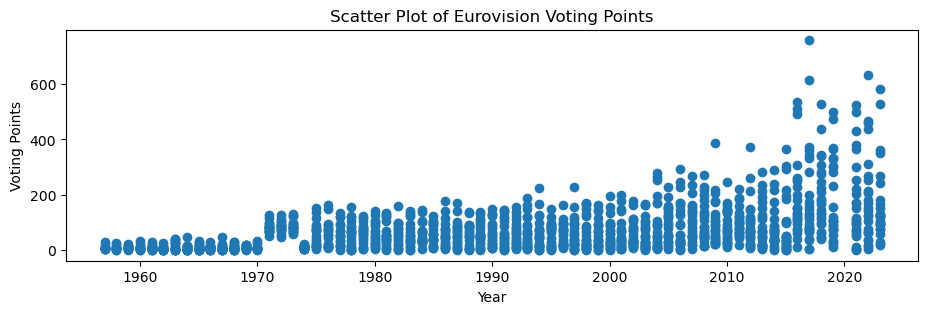

In [82]:
# Extract the relevant columns from the dataframe
year = merged_df['Year']
voting_points = merged_df['Total_Points']

fig,axes=plt.subplots(figsize=(11,3))


# Create the scatter plot
plt.scatter(year, voting_points)

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Voting Points')
plt.title('Scatter Plot of Eurovision Voting Points')

# Display the plot
plt.show()

<div class="alert alert-block alert-info">
<b>Correlation Heatmap: Audio Features vs. Voting Points</b>
</div>

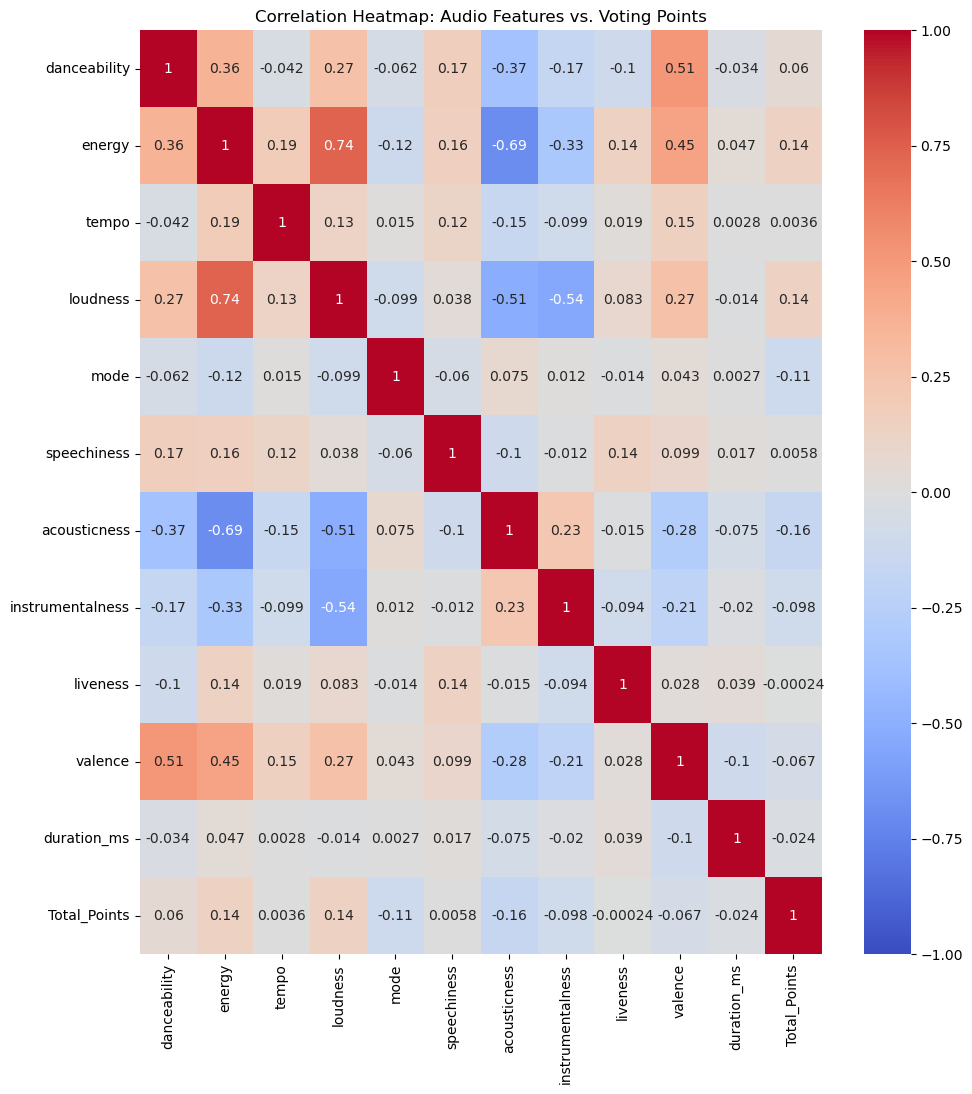

In [43]:

# Extract relevant columns from the dataframe
audio_features = ['danceability', 'energy', 'tempo','loudness','mode','speechiness','acousticness','instrumentalness',
                 'liveness','valence','duration_ms']  # Add more audio features as needed
voting_points = merged_df['Total_Points']

fig,axes=plt.subplots(figsize=(11,12))

# Calculate correlation matrix
correlation_matrix = merged_df[audio_features + ['Total_Points']].corr()

# Plot correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Show the plot
plt.title('Correlation Heatmap: Audio Features vs. Voting Points')
plt.show()


<div class="alert alert-block alert-info">
<b>Box plot or violin plot to compare the audio features of winning songs</b>
</div>

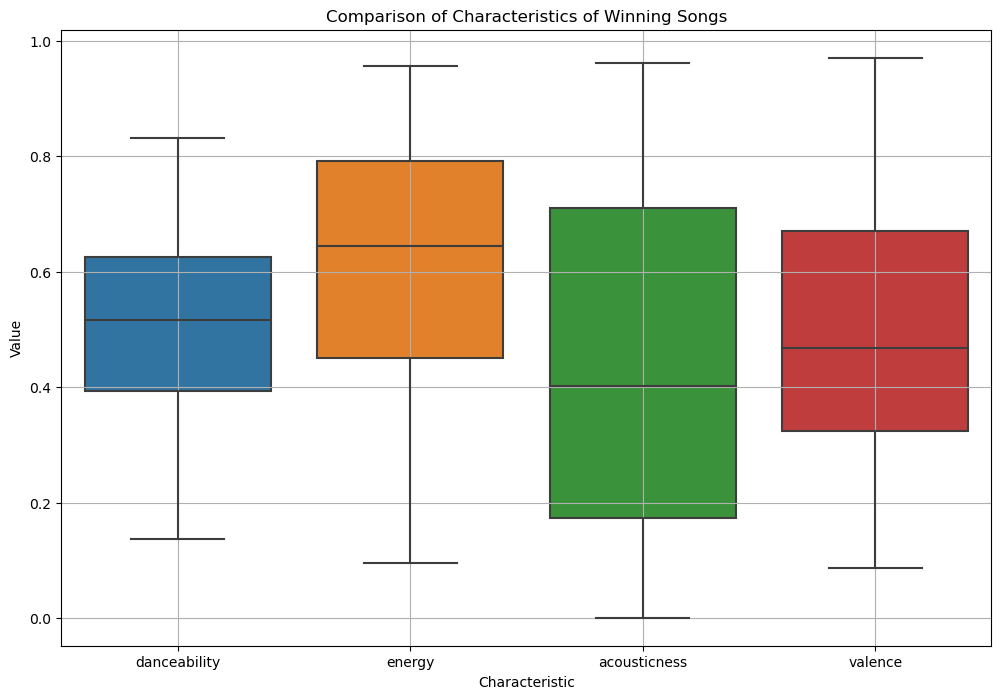

In [44]:
characteristics =  ['danceability', 'energy', 'acousticness', 'valence']    

# Filter the data for only the winning songs
winning_songs = merged_df[merged_df['Rank'] == 1]

# Create a box plot or violin plot to compare the characteristics of winning songs
plt.figure(figsize=(12, 8))
sns.boxplot(data=winning_songs[characteristics])
plt.xlabel('Characteristic')
plt.ylabel('Value')
plt.title('Comparison of Characteristics of Winning Songs')
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<b>Plot for compare the countries of top ranks reached and comparison of average voting points received.</b>
</div>

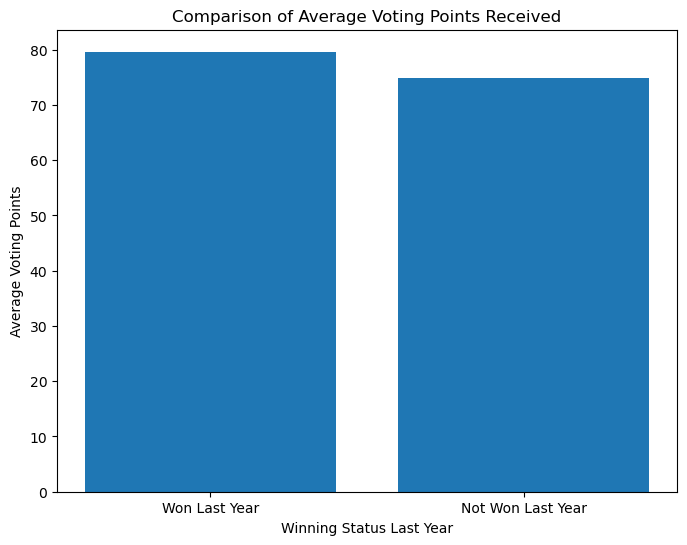

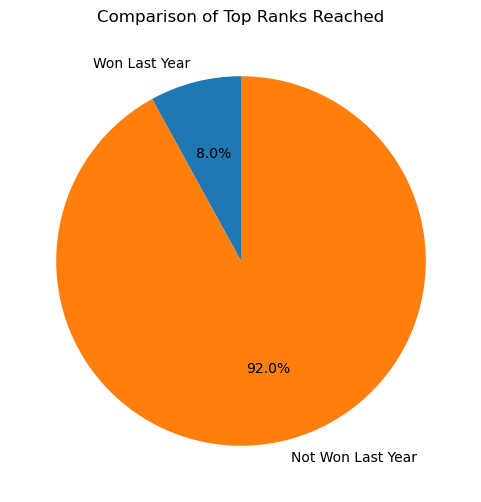

In [45]:
winners_last_year = merged_df[merged_df['won_last_year'] == 1]
avg_points_last_year = winners_last_year['Total_Points'].mean()

# Calculate the average voting points received for countries that didn't win last year
non_winners_last_year = merged_df[merged_df['won_last_year'] == 0]
avg_points_non_last_year = non_winners_last_year['Total_Points'].mean()

# Calculate the number of times countries reached the top ranks (e.g., top 5) based on whether they won last year or not
top_ranks_last_year = winners_last_year[winners_last_year['Rank'] <= 5].shape[0]
top_ranks_non_last_year = non_winners_last_year[non_winners_last_year['Rank'] <= 5].shape[0]

# Create a bar chart to visualize the comparison of average voting points received
plt.figure(figsize=(8, 6))
plt.bar(['Won Last Year', 'Not Won Last Year'], [avg_points_last_year, avg_points_non_last_year])
plt.title('Comparison of Average Voting Points Received')
plt.xlabel('Winning Status Last Year')
plt.ylabel('Average Voting Points')
plt.show()

# Create a pie chart to visualize the comparison of top ranks reached
plt.figure(figsize=(6, 6))
labels = ['Won Last Year', 'Not Won Last Year']
sizes = [top_ranks_last_year, top_ranks_non_last_year]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Comparison of Top Ranks Reached')
plt.show()

<div class="alert alert-block alert-info">
<b>The number of participating countries each year:</b>
</div>

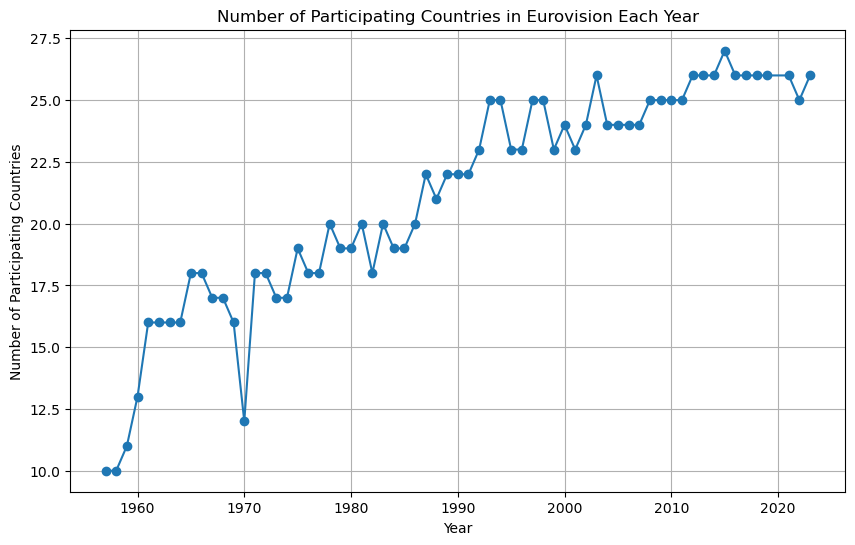

In [46]:
participating_countries = merged_df.groupby('Year')['To_Country'].nunique()

# Create a line plot to visualize the number of participating countries each year
plt.figure(figsize=(10, 6))
plt.plot(participating_countries.index, participating_countries.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Participating Countries')
plt.title('Number of Participating Countries in Eurovision Each Year')
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<b>The average voting points received by winners over the years.</b>
</div>

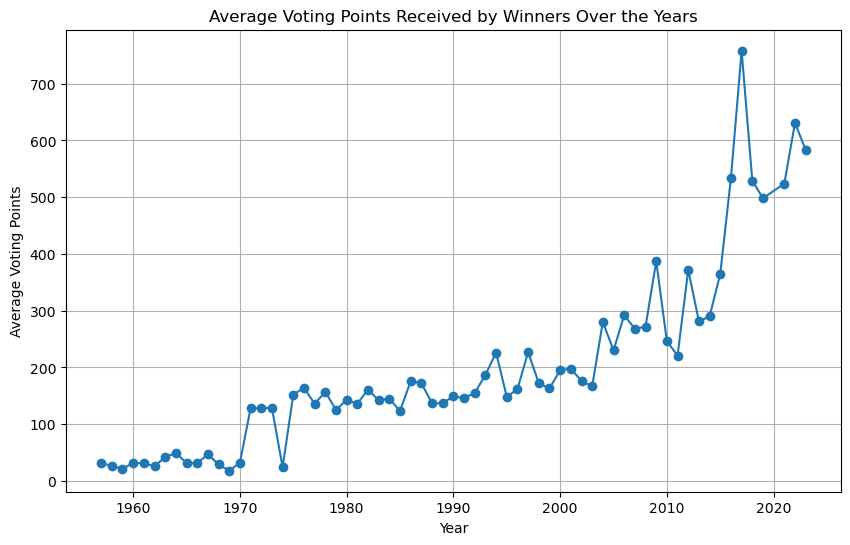

In [47]:
average_winner_points = merged_df[merged_df['Rank'] == 1].groupby('Year')['Total_Points'].mean()

# Create a line plot to visualize the average voting points received by winners over the years
plt.figure(figsize=(10, 6))
plt.plot(average_winner_points.index, average_winner_points.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Average Voting Points')
plt.title('Average Voting Points Received by Winners Over the Years')
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<b>The total wins by each country.</b>
</div>

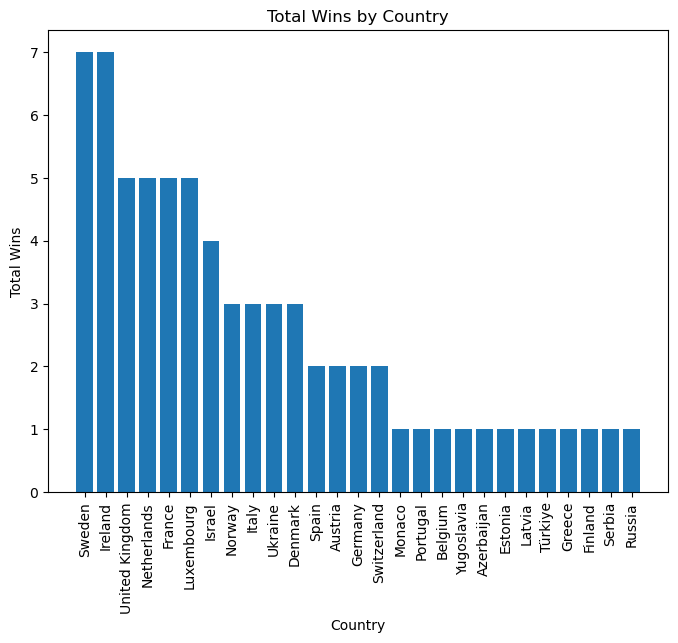

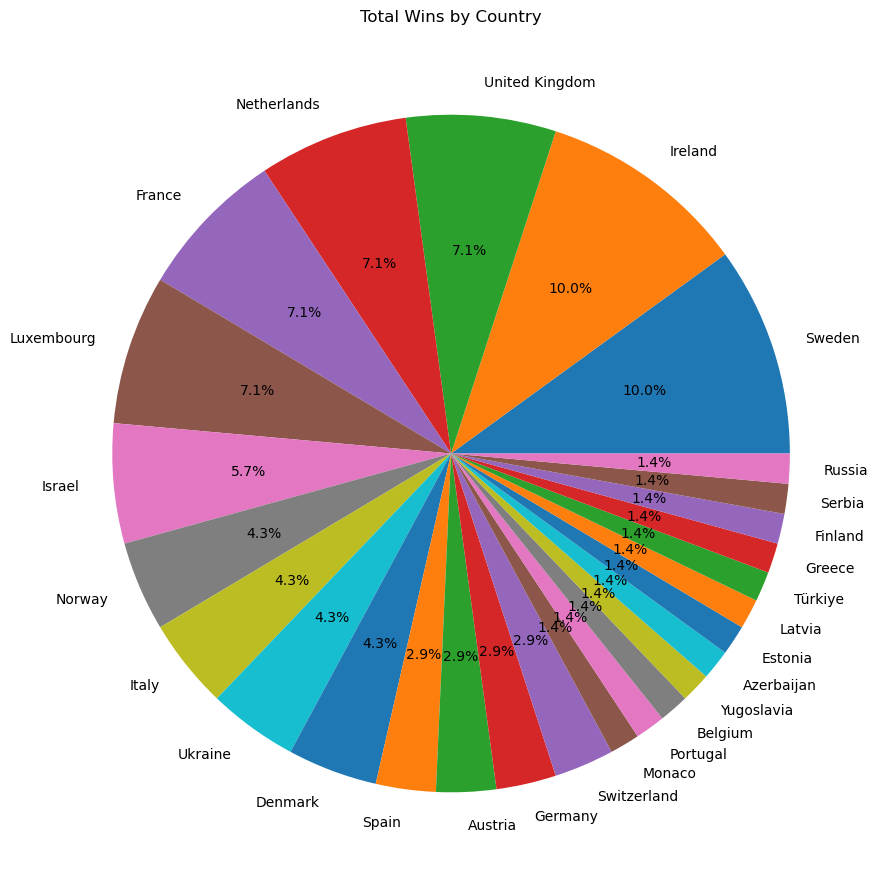

In [48]:
winners_df = winners_df[['Total_Wins','Winner']]
country_wins = winners_df.sort_values('Total_Wins', ascending=False)

country_wins=country_wins.drop_duplicates()
plt.figure(figsize=(8, 6))
plt.bar(country_wins['Winner'], country_wins['Total_Wins'])
plt.xlabel('Country')
plt.ylabel('Total Wins')
plt.title('Total Wins by Country')
plt.xticks(rotation=90)
plt.show()
#countries = selected_df['To_Country']

plt.figure(figsize=(11, 11))
plt.pie(country_wins['Total_Wins'], labels=country_wins['Winner'], autopct='%1.1f%%')
plt.title('Total Wins by Country')
plt.show()

<div class="alert alert-block alert-info">
<b>Here we calculated the total number of participations for each country by counting the occurrences of each country. We also calculated the total number of wins for each country and the success rate is calculated by dividing the total wins by the total participations.Then we are comparing the success rates of different countries and visualize them using a bar chart.</b>
</div>

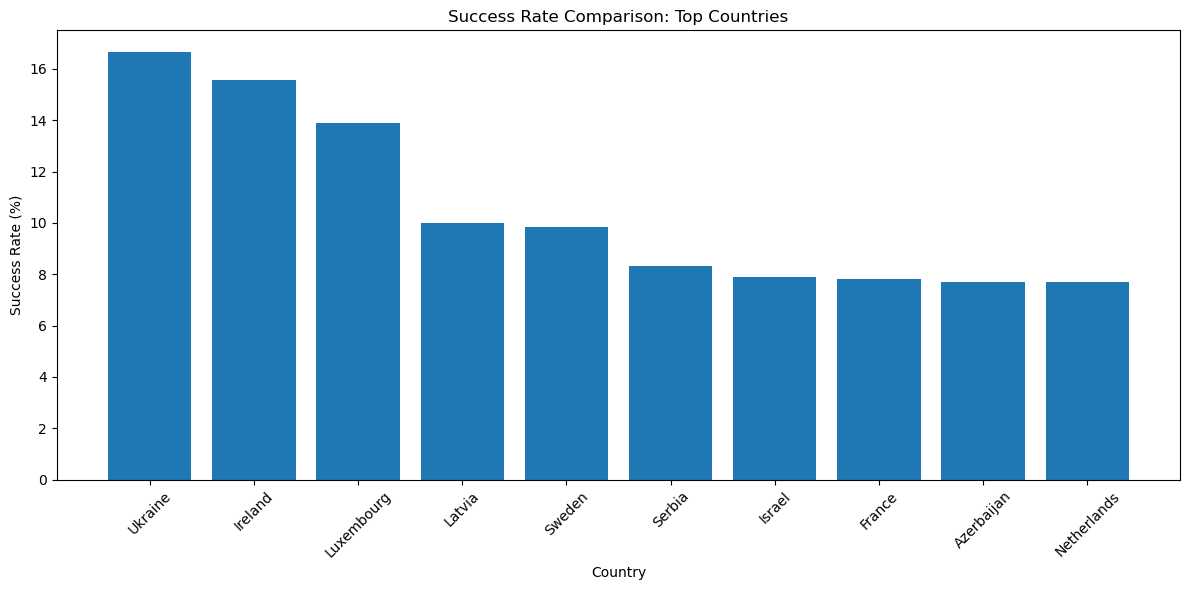

In [49]:

total_participations = merged_df['To_Country'].value_counts().reset_index()
total_participations.columns = ['To_Country', 'Total_Participations']

# Calculate the total number of wins for each country
total_wins = merged_df[merged_df['won_last_year'] == 1]['To_Country'].value_counts().reset_index()
total_wins.columns = ['To_Country', 'Total_Wins']

# Merge the total participations and total wins dataframes
country_stats = total_participations.merge(total_wins, on='To_Country', how='left')

# Calculate the success rate by dividing the total wins by the total participations
country_stats['Success_Rate'] = (country_stats['Total_Wins'] / country_stats['Total_Participations']) * 100
country_stats=country_stats.fillna(0)
country_stats['Success_Rate'] = country_stats['Total_Wins'] / country_stats['Total_Participations'] * 100

country_stats = country_stats.sort_values('Success_Rate', ascending=False)
# Extract the top N countries with highest success rates
top_countries = country_stats.head(10)

# Plot the success rates of top countries
plt.figure(figsize=(12, 6))
plt.bar(top_countries['To_Country'], top_countries['Success_Rate'])
plt.xlabel('Country')
plt.ylabel('Success Rate (%)')
plt.title('Success Rate Comparison: Top Countries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Comparing the performance of countries by plotting their wins up to the year over time using a line plot.</b>
</div>

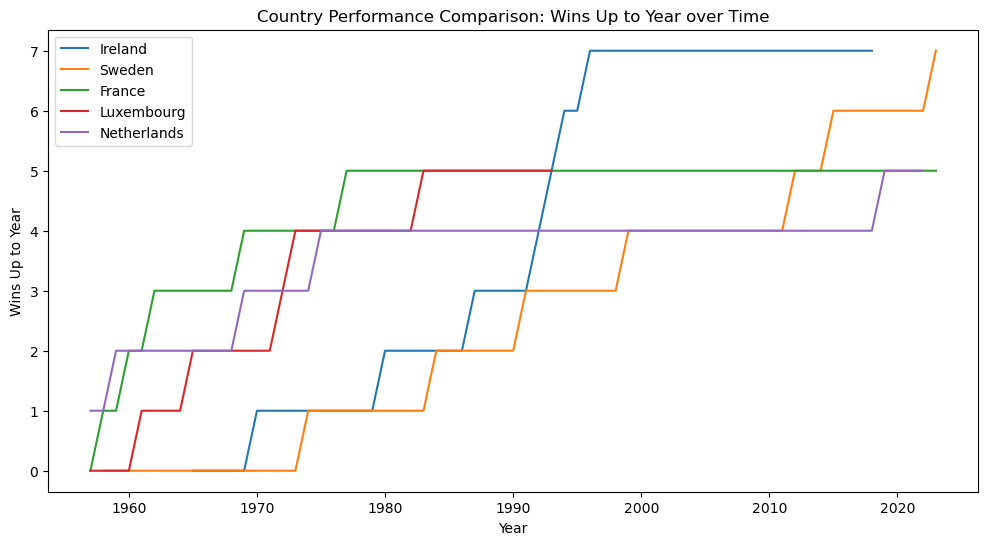

In [50]:
country_performance = merged_df.groupby('To_Country')['wins_up_to_the_year'].max()

# Sort the countries based on their total wins
country_performance = country_performance.sort_values(ascending=False)

# Select the top N countries to compare
top_countries = country_performance.head(5)

# Create an empty list to store the wins up to the year for each country
wins_data = []

# Iterate over the top countries and extract their wins up to the year data
for country in top_countries.index:
    # Get the wins up to the year for the country
    wins_up_to_year = merged_df[merged_df['To_Country'] == country]['wins_up_to_the_year']
    wins_data.append(wins_up_to_year.tolist())  # Convert to a list and add to the wins_data list

# Create a line plot for each country's wins up to the year
fig, ax = plt.subplots(figsize=(12, 6))

for country, wins_up_to_year in zip(top_countries.index, wins_data):
    # Get the corresponding years for the country's wins up to the year
    years = merged_df[merged_df['To_Country'] == country]['Year']
    
    # Plot the line for the country's performance
    ax.plot(years, wins_up_to_year, label=country)

# Set the labels and title of the plot
ax.set_xlabel('Year')
ax.set_ylabel('Wins Up to Year')
ax.set_title('Country Performance Comparison: Wins Up to Year over Time')

# Display a legend
ax.legend()

# Show the plot
plt.show()

## Machine learning

### Logistic Regression

In [62]:
#features = ['Total_Points','wins_up_to_the_year','won_last_year','energy','loudness','danceability',
#           'mode','speechiness','acousticness','liveness','valence','tempo','Top5_Count']
features=['Total_Participations_Up_To_The_Year','Total_Points','wins_up_to_the_year','won_last_year',
          'energy','danceability','Top3_Count']
#df_copy=merged_df[merged_df['Year']>=2000]

# Split the data into training and testing sets
X = merged_df[features]
y = merged_df['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

scaler = StandardScaler()

# Scale the numerical features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
clf_model  = LogisticRegression()

# Train the model on the training data
clf_model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = clf_model.predict(X_test_scaled)

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

predictions_df = pd.DataFrame({'Actual Winner': y_test, 'Predicted Winner': y_pred})
predictions_df['Correct Prediction'] = (predictions_df['Actual Winner'] == predictions_df['Predicted Winner']).astype(int)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Precision Score:",precision)
print("Confusion Matrix:\n",conf_mat)

Accuracy: 0.9519230769230769
Recall: 0.22727272727272727
F1 Score: 0.3333333333333333
Precision Score: 0.625
Confusion Matrix:
 [[391   3]
 [ 17   5]]


In [57]:
predictions_df

,Actual Winner,Predicted Winner,Correct Prediction
1140,0,0,1
229,0,0,1
169,0,0,1
753,0,0,1
49,0,0,1
...,...,...,...
286,0,0,1
288,0,0,1
1303,0,0,1
1332,0,1,0


### KNN

In [63]:

#features = ['Total_Points','wins_up_to_the_year','won_last_year','energy','loudness','danceability',
#           'mode','speechiness','acousticness','liveness','valence','tempo']

features=['Total_Participations_Up_To_The_Year','Total_Points','wins_up_to_the_year','won_last_year',
          'energy','danceability','Top3_Count']

# Split the data into training and testing sets
X = merged_df[features]
y = merged_df['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

k = 3 # number of nearest neighbors
model = KNeighborsClassifier(n_neighbors=k)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
evaluate_value =f1_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)


print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Precision Score:",precision)
print("Confusion Matrix:\n",conf_mat)

Accuracy: 0.9423076923076923
Recall: 0.3181818181818182
F1 Score: 0.3333333333333333
Precision Score: 0.4375
Confusion Matrix:
 [[385   9]
 [ 15   7]]


C:\Users\Teo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


###  Naive Bayes

In [64]:
#features = ['Total_Points','wins_up_to_the_year','won_last_year','energy','loudness','danceability',
#         'mode','speechiness','acousticness','liveness','valence','tempo','Top5_Count']
features=['Total_Participations_Up_To_The_Year','Total_Points','wins_up_to_the_year','won_last_year',
          'energy','danceability','Top3_Count']

# Split the data into training and testing sets
X = merged_df[features]
y = merged_df['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Naive Bayes classifier
model = GaussianNB()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
evaluate_value =f1_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)


print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Precision Score:",precision)
print("Confusion Matrix:\n",conf_mat)

Accuracy: 0.9086538461538461
Recall: 0.2727272727272727
F1 Score: 0.3333333333333333
Precision Score: 0.21428571428571427
Confusion Matrix:
 [[372  22]
 [ 16   6]]


## Results and conclusions

<div class="alert alert-block alert-info">
<b>
    <ul>
      <li>In the logistic regression model, the accuracy achieved was 0.9519, indicating a high level of correct predictions. The recall score, which measures the proportion of actual positive cases correctly identified, was 0.2273. The F1 score, a balanced measure of precision and recall, was 0.3333, and the precision score, which represents the proportion of true positive cases out of the predicted positive cases, was 0.625.</li>
      <li>In the KNN (K-Nearest Neighbors) model, the accuracy achieved was 0.9423, indicating a high level of correct predictions. The recall score, which measures the proportion of actual positive cases correctly identified, was 0.3182. The F1 score, a balanced measure of precision and recall, was 0.3333, and the precision score, which represents the proportion of true positive cases out of the predicted positive cases, was 0.4375.m</li>
     <li>In the Naive Bayes model, the accuracy achieved was 0.90625, indicating a good level of overall accuracy. The recall score, which measures the proportion of actual positive cases correctly identified, was 0.2727. The F1 score, a balanced measure of precision and recall, was 0.3333, and the precision score, which represents the proportion of true positive cases out of the predicted positive cases, was 0.2069.</li>
    </ul>
 </b>
</div>


<div class="alert alert-block alert-info">
<b> Based on the evaluation metrics obtained for the Logistic Regression, K-Nearest Neighbors (KNN), and Naive Bayes algorithms, it can be observed that Logistic Regression achieved the highest accuracy (0.9519), followed by KNN (0.9423) and Naive Bayes (0.9063). In terms of recall, KNN had the highest score (0.3182), indicating its ability to identify a higher proportion of positive cases. However, the F1 score and precision score were relatively low for all three algorithms. It can be concluded that machine learning models can be used to predict the winner of Eurovision.</b>
</div>